<a href="https://colab.research.google.com/github/antadama/machine-learning/blob/master/TP_TextDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Détection de thèses relevantes de l'IA

## Collection de données 
Ce TP utilisera l'ensemble de données issues du 
[Fichier de données](https://moodle.uphf.fr/pluginfile.php/223849/mod_assign/introattachment/0/Traitement%20des%20theses.ods?forcedownload=1) déposé sur Moodle à cet effet.

Dans ce document des thèses récentes sont classées; les noms des auteurs ont été retirés (ils peuvent facilement être retrouvés  mais ne sont pas utiles ici); les noms des directeurs de thèses ont été légèrement cryptés (pour éviter la diffusion de noms dans le cadre de TP).
Quelques entrées sont manquantes (thèses non classées, absence de nom de directeur, plusieurs directeurs..)

Nous allons d'abord "nettoyer" ces entrées, puis créer un classifieur (inspiré de la Détection de sentiments vue en TD).

La quantité de données à résultat positif étant inférieure à celles à résultat négatif,nous allons en utiliser un certain nombre en données d'entraînement et d'autres en données de test.


---
**Pré-requis:**
A la racine de votre Drive Google, vous pouvez créer un dossier "TP IA" et y ajouter le fichier de données "Traitement des theses.ods"
Sinon, il faudra modifier les chemins dans les lignes de codes suivant.

Exécutez le code suivant,  une clé vous sera demandée. Il vous suffit de suivre le lien, de sélectionner votre profile pour obtenir votre clé que vous copierez dans le champs prévu.

In [1]:
#bloc à exécuter si vous utilisez colab
from google.colab import drive, files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## Préparation des données


### Chargement et nettoyage des données

Il convient pour chaque fichier texte de 
  - identifier les termes (**tokens**) entre espaces,
  - supprimer toute ponctuation,
  - supprimer tous les mots qui ne sont pas uniquement composés de caractères alphabétiques,
  - supprimer tous les mots reconnus en tant que mots vides (stop words) (mots de liaison)
  - supprimer tous les mots dont la longueur est <= 1 caractère.

### Les bibliothèques
La préparation des données implique de pouvoir accéder au système de fichier, ainsi qu'à la bibliothèque nltk et aux bibliothèques spécialisées dans le traitement de texte.. : 

In [2]:
##import pour les fichiers et le traitement de données : 
from os import listdir

##import pour la creation de tokens
import nltk
from nltk.corpus import stopwords

##import pour la gestion de ponctuation
from string import punctuation

##import pour une collection spécifique : counter
from collections import Counter

##import pour les réseaux de neurones : 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import preprocessing

##import classique pour les tableaux efficaces
from numpy import array, zeros

##import pour la lecture de fichier excel
import pandas as pd
!pip install odfpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# le code suivant charge l'ensemble des mots non importants
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Fonctions de lectures et d'"épurage" de fichier texte

Pour le traitement des entrées, j'ai enlevé la ponctuation, les stopwords connus en français et anglais, les mots de moins de 2 lettres. Chaque mot est changé en minuscule, les nombres et autres caractères numériques sont également retirés.
Je ne considère que les mots du titre, donc les auteurs, date de parution etc ne sont pas consultés.

Les champs retenus du fichier excel sont la colonne "IA ?" et la colonne Titre.

In [4]:
def read_excel_file(filename):
    """Lit le fichier filename puis retourne une dataframe avec les titres et la colonne 'IA ?' qui y sont inscrites """
    
    # Load file in dataframe
    df = pd.concat(pd.read_excel(filename, sheet_name=None, engine="odf"), ignore_index=True)
    # keep the needed columns
    df = df[['IA ?', 'Titre']]
    return df

 
def save_examples(titles_df):
    """Crée les fichiers pour l'apprentissage (avec les titres)"""
    pos_titles = titles_df[titles_df['IA ?']=="Oui"]
    neg_titles = titles_df[titles_df['IA ?']=="Non"]

    neg_titles[["Titre"]].to_csv(r'/content/drive/My Drive/TP IA/negatives.txt', header=None, index=None, sep='\n', mode='a')
    pos_titles[["Titre"]].to_csv(r'/content/drive/My Drive/TP IA/positives.txt', header=None, index=None, sep='\n', mode='a')
    print("Examples saved.")


def load_doc(filename)->str:
    """retourne le texte inclus dans le fichier filename"""
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
    
def clean_doc(doc)->list:
    """retourne la liste de mots clés inclus dans le texte doc 
    qui ne font pas parti des stop_words"""
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words_english = set(stopwords.words('english'))
    stop_words_french = set(stopwords.words('french'))
    tokens = [w for w in tokens if not w in stop_words_french]
    tokens = [w for w in tokens if not w in stop_words_english]
    #Turn all words to lowercase
    tokens = [w.lower() for w in tokens]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]

    return tokens

### Tests de la récupération de mots clés d'un fichier

In [5]:
rep = '/content/drive/My Drive/TP IA'

df = read_excel_file(rep + "/Traitement des theses.ods")
save_examples(df)

# mots clés du fichier négatif
filename = rep + '/negatives.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print('les 10 premiers mots cles de ', filename)
print(tokens[:10])

# mots clés du fichier positif
filename = rep + '/positives.txt'
text = load_doc(filename)
tokens = clean_doc(text)
print('les 10 premiers mots cles de ', filename)
print(tokens[:10])


Examples saved.
les 10 premiers mots cles de  /content/drive/My Drive/TP IA/negatives.txt
['preventing', 'release', 'illegitimate', 'applications', 'mobile', 'markets', 'contextaware', 'recommender', 'system', 'system']
les 10 premiers mots cles de  /content/drive/My Drive/TP IA/positives.txt
['methodes', 'outils', 'programmation', 'systemes', 'cyberphysiques', 'fouille', 'donnees', 'spatiotemporelles', 'resumes', 'donnees']


### Construire le vocabulaire global

Il ya environ +5000 données avec un résultat positif et +15000 avec resultat négatif.
Le nombres de titres négatifs ou positifs appris et testés est le même; ces nombres doivent donc être définis en avance.

In [6]:
#Variable globales (nb_learn + nb_test <=5000)

#Nombre de titres pour l'apprentissage
nb_learn = 1000

#Nombres de titres pour les tests
nb_test = 1000

In [7]:
def add_doc_to_vocab(doc, vocab):
    """cumule dans la liste vocab les mots du texte doc """
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

def build_voc(filename, vocab, nb_learn):
    """ajoute au dictionnaire vocab les mots cles des nb_learn premières lignes 
  du fichier filename"""
  
    with open(filename, 'r') as fp:
      lines =fp.readlines()
    var = "\n".join(lines[:nb_learn])
    # add doc to vocab
    add_doc_to_vocab(var, vocab)

    
# creer un vocabulaire (liste de mots clés associés à leurs occurences)
vocab = Counter()
# ajouter les mots cles des repertoire pos et neg
build_voc(rep + "/positives.txt", vocab, nb_learn)
build_voc(rep + "/negatives.txt", vocab, nb_learn)


# afficher le nb de mots cles trouves
print("nb de mots cles trouves dans les repertoires : ", len(vocab))
print("les 10 premiers mots cles du vocabulaire \
(et leur nb d\'apparition dans les exemples)  : \n", end='')
i=0
for (mot,count) in vocab.items(): 
    print(mot,':',count,end=", ")
    i = i+1
    if i>10:break
# afficher les 10 mots cles les plus utilises
print("\nles 10 mots cles les plus utilises : ", vocab.most_common(10))


nb de mots cles trouves dans les repertoires :  3917
les 10 premiers mots cles du vocabulaire (et leur nb d'apparition dans les exemples)  : 
methodes : 59, outils : 18, programmation : 23, systemes : 136, cyberphysiques : 9, fouille : 19, donnees : 115, spatiotemporelles : 9, resumes : 6, apprentissage : 100, automatique : 64, 
les 10 mots cles les plus utilises :  [('application', 139), ('systemes', 136), ('reseaux', 117), ('donnees', 115), ('detection', 109), ('apprentissage', 100), ('learning', 100), ('dun', 89), ('applications', 83), ('modeles', 78)]


In [8]:
# ne garder que les mots clés apparaissant au moins 3 fois
min_occurrence = 3
tokens = [token for (token,count) in vocab.items() if count >= min_occurrence]
print('en otant les mots utilise moins de ', min_occurrence, ' fois, nb de mots cles = ',len(tokens))

en otant les mots utilise moins de  3  fois, nb de mots cles =  1314


In [9]:
def save_list(lines, filename):
    """save les mots de la liste lines dans le fichier filename"""
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, rep + '/vocab.txt')

---
## Représentation en sac de mots

### Convertir les fichiers en listes de mots-clés appartenant au vocabulaire 


In [10]:
def doc_to_line(doc, vocab)->list:
    """retourne les mots cles du texte doc appartenant au vocabulaire vocab"""
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    return ' '.join(tokens)

In [11]:
doc_to_line('Methodes et hahaha outils pour la programmation des systemes cyber-physiques.\n', vocab)

'methodes outils programmation systemes cyberphysiques'

In [12]:
def process_docs(filename, vocab, nb_learn, nb_test)->list:
    """retourne deux listes des mots cles du repertoire directory; 
    la 1ere liste represente les nb_learn premières lignes des thèses du repertoire, 
    la 2nde represente les nb_test dernières """
    lines_firsts = list()
    lines_lasts = list()
    
    # load the file and clean the lines
    with open(filename, 'r') as fp:
      lines =fp.readlines()
    
    for l in lines[:nb_learn]:
      line = doc_to_line(l, vocab)
      lines_firsts.append(line)

    for l_2 in lines[-nb_test:]:
      line = doc_to_line(l_2, vocab)
      lines_lasts.append(line)

    return (lines_firsts,lines_lasts)


In [13]:
# load the vocabulary
vocab_filename = rep + '/vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
# load training and testing reviews
(positive_lines_train, positive_lines_test) = process_docs(rep+'/positives.txt', vocab, nb_learn, nb_test)
(negative_lines_train, negative_lines_test) = process_docs(rep+'/negatives.txt', vocab, nb_learn, nb_test)

# summarize what we have
print("nb exemples d'entrainement positifs : ", len(positive_lines_train))
print("nb exemples d'entrainement negatifs : ", len(negative_lines_train))
print("nb exemples de tests positifs : ", len(positive_lines_test))
print("nb exemples de tests negatifs : ", len(negative_lines_test))

nb exemples d'entrainement positifs :  1000
nb exemples d'entrainement negatifs :  1000
nb exemples de tests positifs :  1000
nb exemples de tests negatifs :  1000



### Convertir les listes de mots en vecteur fréquence d'apparition 
#### Créer le sac de mot de l'ensemble d'entrainement

In [14]:
# create the tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()
# build the training doc by adding first positive lines and then negative lines
training_doc = [None]*(len(positive_lines_train)+len(negative_lines_train))
#place the positive lines first
training_doc[:len(positive_lines_train)] = positive_lines_train
#place the negative lines until the end
training_doc[len(negative_lines_train):] = negative_lines_train
# ask to the tokenizer to build the bag of words : a set of (word, frequence of use)*
tokenizer.fit_on_texts(training_doc)
xTrain = tokenizer.texts_to_matrix(training_doc, mode='binary')

In [15]:
print('Xtrain contient ', xTrain.shape[0], ' exemples de ', xTrain.shape[1], ' valeurs')
print('une valeur = fréquence d\'apparition des mots dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entrainement = \n', xTrain[150])

Xtrain contient  2000  exemples de  1315  valeurs
une valeur = fréquence d'apparition des mots dans le vocabulaire global.
Ainsi, premier exemple d'entrainement = 
 [0. 0. 0. ... 0. 0. 0.]


On décide que les exemples positifs correspondent à une sortie 0 et que les exemples négatifs correspondent à la sortie 1 :

In [16]:
#ytrain = suite de (0 (classement pour eval positive) puis 1 (classements pour éval négative))
yTrain = zeros(len(positive_lines_train)+len(negative_lines_train), int)
yTrain[len(negative_lines_train):] = 1

#### Créer le sac de mot de l'ensemble de validation

In [17]:
# build the test doc by alternating positive lines and negative lines
test_Doc = [None]*(len(positive_lines_test)+len(negative_lines_test))

#place a positive line at even positions (0,2,....)
test_Doc[::2] = positive_lines_test
#place a negative line at odd positions (1,3,....)
test_Doc[1::2] = negative_lines_test
# ask to the tokenizer to give the bag of words : a set of (word, frequence of use),
# the words are already kown by the tokenizer*
xTest = tokenizer.texts_to_matrix(test_Doc, mode='binary')
print('Xtest contient ', xTest.shape[0], ' exemples de ', xTest.shape[1], ' valeurs.')

Xtest contient  2000  exemples de  1315  valeurs.


In [18]:
#sortie attendues des exemples de test, ytest = suite de (0, 1)
yTest = array([0,1]*(len(positive_lines_test)))

---
## Modèle de réseau pour l'analyse des sentiments
Le réseau contient en couche d'entrée aurant de neurones que de valeurs retenues

Plusieurs tests ont été fait: 
- Avec 4 couches
- Avec l'optimiseur sgd puis adam
- Fonctions d'activation: elu pour la couche d'entrée, relu pour celles intermédiaires, sigmoid pour la couche de sortie
- Avec 20 et 100 epochs 

Le model sera sauvegardé dans le dossier "TP IA" sur le drive (il est également disponible avec le rendu de ce TP)


In [19]:
# Donner le nb de neurones en entrée (= nb de tokens retenus)
n_words = xTrain.shape[1] 

In [20]:
# Définir la structure du réseau
model = Sequential()
model.add(Dense(300, input_shape=(n_words,), activation='elu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile network 
model.compile(loss='hinge', optimizer='adam',  metrics=['accuracy'])


In [21]:
#Tester differents nb de tests (epochs)
history = model.fit(xTrain, yTrain, 
                    validation_data=(xTest, yTest),
                    epochs=20, verbose=1)

#Sauvegarder le model
model.save(rep+"/model_save/")

Epoch 1/20
63/63 [==============================] - 2s 22ms/step - loss: 0.9046 - accuracy: 0.6965 - val_loss: 0.7236 - val_accuracy: 0.8165
Epoch 2/20
63/63 [==============================] - 1s 15ms/step - loss: 0.6429 - accuracy: 0.8755 - val_loss: 0.6302 - val_accuracy: 0.8770
Epoch 3/20
63/63 [==============================] - 1s 15ms/step - loss: 0.5848 - accuracy: 0.9210 - val_loss: 0.6013 - val_accuracy: 0.9035
Epoch 4/20
63/63 [==============================] - 1s 13ms/step - loss: 0.5637 - accuracy: 0.9390 - val_loss: 0.5917 - val_accuracy: 0.9130
Epoch 5/20
63/63 [==============================] - 1s 15ms/step - loss: 0.5582 - accuracy: 0.9455 - val_loss: 0.5958 - val_accuracy: 0.9065
Epoch 6/20
63/63 [==============================] - 1s 13ms/step - loss: 0.5535 - accuracy: 0.9485 - val_loss: 0.5884 - val_accuracy: 0.9125
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 0.5506 - accuracy: 0.9500 - val_loss: 0.5817 - val_accuracy: 0.9200
Epoch 8/20
63

### Dessiner l'évolution de l'erreur et de la pertinence

#### Résultats 

1) Pour 3000 exemples d'entrainement et 500 exemples pour tester, à 100 epochs et l'optimiseur adam, nous obtenons 98 % de précision.

2) A 20 epochs, il faut diminuer le nombres d'exemples respectivement à 1000 (chacun) pour obtenir 91 % de précision.

Les images suivantes sont les résultats avec le modèle (1):


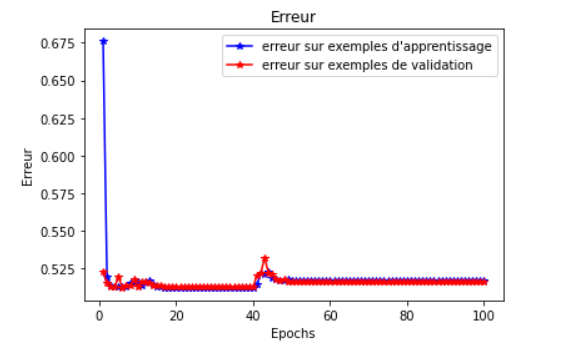

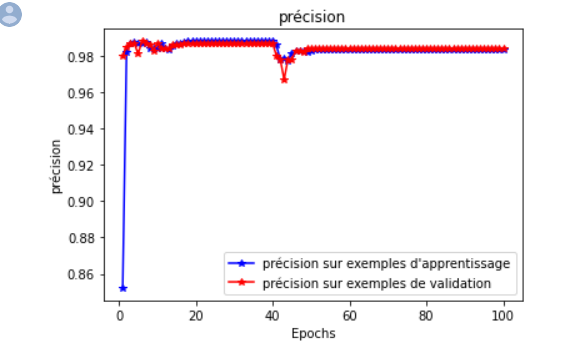

In [22]:
history_dict = history.history

#### Tracer l'erreur d'entrainement / l'erreur de validation
- L'erreur d'entrainement et l'erreur de validation doivent suivre des courbes quasi parallèle.
- L'erreur d'entrainement doit être plus faible que l'erreur de validation
    - si les courbes divergent, si la courbe de validation s'éloigne de la courbe d'entrainement, il y a alors un sur-apprentissage (overfitting) trop adapté aux données d'entrainement, sans doute trop poussé (diminuer les epochs?).
    - s'il y a une erreur d'entrainement trop grande, il y a sous-apprentissage

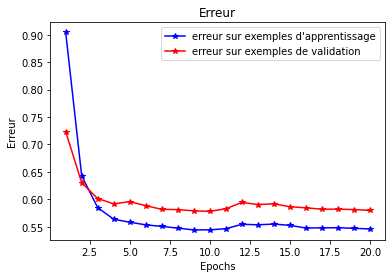

In [23]:
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

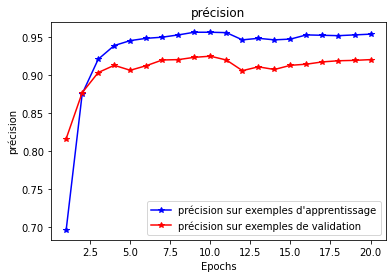

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

### Evaluer le modèle sur l'exemple d'entrainement

In [25]:
# evaluate
loss, acc = model.evaluate(xTest, yTest, verbose=0)
print('Précision sur exemples de test: %f' % (acc*100))

Précision sur exemples de test: 92.049998


---
## Estimation de nouvelles valeurs
Il ne reste plus qu'à utiliser le réseau pour faciliter la classification de futures thèses 

In [26]:
def predict_sentiment(review, vocab, tokenizer, model):
    """classifie le texte dans la variable 'review' en positif (0) ou negatif (1) """
    # clean
    tokens = clean_doc(review)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # convert to line
    line = ' '.join(tokens)
    # create the bag of words with the words used in the line
    encoded = tokenizer.texts_to_matrix([line], mode='binary')
    # prediction, output is a vector of (1x1) here (output of the neural network is a vector of 1 element)
    output = model.predict(encoded, verbose=0)
    estimation = output[0,0]
    return estimation

In [27]:
# test avec des thèses relevantes de l'IA
text = "Applications of Foundational Proof Certificates in theorem proving"
#text = "Generation of communicative intentions for virtual agents in an intelligent virtual environment : application to virtual learning environment"
resultat = predict_sentiment(text, vocab, tokenizer, model)
print('\'',text,'\' ------> est considere comme', 'une thèse IA' if resultat<0.5 else 'une thèse non IA')
print(resultat)
print("=-=-=-=-=-=-=-=-=-=-=-=")


# test avec des thèse non relevantes 
text = "Hypergraphes multimedias diriges navigables, construction et exploitation"
#text = "An evidential answer for the capacitated vehicle routing problem with uncertain demands"
resultat = predict_sentiment(text, vocab, tokenizer, model)
print('\'',text,'\' ------> est considere comme', 'une thèse IA' if resultat<0.5 else 'une thèse non IA')
print(resultat)



' Applications of Foundational Proof Certificates in theorem proving ' ------> est considere comme une thèse non IA
0.99999714
=-=-=-=-=-=-=-=-=-=-=-=
' Hypergraphes multimedias diriges navigables, construction et exploitation ' ------> est considere comme une thèse non IA
0.9974397
